In [1]:
import os
import json, urllib, requests
import pandas as pd
import datetime
import seaborn as sns
import pylab as plt
import matplotlib.dates as mdates
from pandas.io.json import json_normalize
epoch = datetime.datetime.utcfromtimestamp(0)
def unix_time_millis(dt):
    return int((dt - epoch).total_seconds() * 1000.0)

## Getting all events for a release

In [2]:
def get_events(issue_id, token):
    cutoff_cursor = unix_time_millis(datetime.datetime.now() - datetime.timedelta(days=90))

    all_events = []
    results = True
    url = "https://sentry.io/api/0/issues/%s/events/"%issue_id
    counter = 0
    while True:
        r = requests.get(url, 
                         headers={'Authorization': 'Bearer %s' % token})
        
        try:
            events_json = r.json()
        except:
            print(r)
            raise
        
        for event in events_json:
            for tag in event['tags']:
                if tag['key'] == 'environment' and tag['value'] in 'prod':
                    all_events.append(event)
        cursor = r.headers['Link'].split(',')[1].split(';')[3].split('=')[1].replace('"', '')
        results_str = r.headers['Link'].split(',')[1].split(';')[2].split('=')[1].replace('"', '')
        print(results_str)
        results = results_str.strip() == 'true'
        print(r.headers['Link'])
        new_url = "https://sentry.io/api/0/issues/%s/events/?cursor=%s"%(issue_id, cursor)
        print(cursor)
        if not results:
            break
        url = new_url
        
    for e in all_events:
        e['tags'] = dict([(a['key'], a['value']) for a in e['tags']])
    
    all_events_df =json_normalize(all_events)
    
    all_events_df.dateCreated = pd.to_datetime(all_events_df.dateCreated)
    
    all_events_df['date_minus_time'] = all_events_df["dateCreated"].apply( lambda df : datetime.datetime(year=df.year, month=df.month, day=df.day))
    all_events_df['date_minus_time'] = all_events_df['date_minus_time'] - pd.to_timedelta(7, unit='d')
    all_events_df.set_index(all_events_df["date_minus_time"], inplace=True)
    
    return all_events_df

In [3]:
all_successful_events_df = get_events("758615130", os.environ['SENTRY_TOKEN'])

true
<https://sentry.io/api/0/issues/758615130/events/?&cursor=1553360355000:0:1>; rel="previous"; results="false"; cursor="1553360355000:0:1", <https://sentry.io/api/0/issues/758615130/events/?&cursor=1553284493000:0:0>; rel="next"; results="true"; cursor="1553284493000:0:0"
1553284493000:0:0
true
<https://sentry.io/api/0/issues/758615130/events/?&cursor=1553284493000:0:1>; rel="previous"; results="true"; cursor="1553284493000:0:1", <https://sentry.io/api/0/issues/758615130/events/?&cursor=1553232845000:0:0>; rel="next"; results="true"; cursor="1553232845000:0:0"
1553232845000:0:0
true
<https://sentry.io/api/0/issues/758615130/events/?&cursor=1553232845000:0:1>; rel="previous"; results="true"; cursor="1553232845000:0:1", <https://sentry.io/api/0/issues/758615130/events/?&cursor=1553210184000:0:0>; rel="next"; results="true"; cursor="1553210184000:0:0"
1553210184000:0:0
true
<https://sentry.io/api/0/issues/758615130/events/?&cursor=1553210184000:0:1>; rel="previous"; results="true"; cu

In [4]:
all_started_events_df = get_events("540334560", os.environ['SENTRY_TOKEN'])

true
<https://sentry.io/api/0/issues/540334560/events/?&cursor=1553362748000:0:1>; rel="previous"; results="false"; cursor="1553362748000:0:1", <https://sentry.io/api/0/issues/540334560/events/?&cursor=1553345549000:0:0>; rel="next"; results="true"; cursor="1553345549000:0:0"
1553345549000:0:0
true
<https://sentry.io/api/0/issues/540334560/events/?&cursor=1553345549000:0:1>; rel="previous"; results="true"; cursor="1553345549000:0:1", <https://sentry.io/api/0/issues/540334560/events/?&cursor=1553323245000:0:0>; rel="next"; results="true"; cursor="1553323245000:0:0"
1553323245000:0:0
true
<https://sentry.io/api/0/issues/540334560/events/?&cursor=1553323245000:0:1>; rel="previous"; results="true"; cursor="1553323245000:0:1", <https://sentry.io/api/0/issues/540334560/events/?&cursor=1553304555000:0:0>; rel="next"; results="true"; cursor="1553304555000:0:0"
1553304555000:0:0
true
<https://sentry.io/api/0/issues/540334560/events/?&cursor=1553304555000:0:1>; rel="previous"; results="true"; cu

In [5]:
suc_ids = all_successful_events_df['tags.run_uuid'].unique()
all_ids = all_started_events_df['tags.run_uuid'].unique()

all_successful_events_df2 = all_started_events_df[all_started_events_df['tags.run_uuid'].isin(suc_ids)]

## Successful runs per week

C:\Users\me\Miniconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


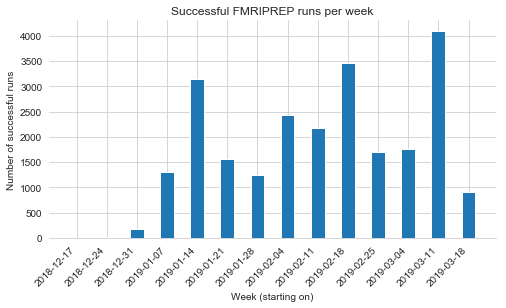

In [6]:
sns.set_style("whitegrid")
grouped_df = all_successful_events_df[['date_minus_time', 'id']].resample('W-Mon', on='date_minus_time')['id'].count()
fig,ax = plt.subplots(figsize=(8,4))
plt.bar(grouped_df.index, grouped_df.values, width=3.2)
plt.ylabel("Number of successful runs")
plt.xlabel("Week (starting on)")
plt.title("Successful FMRIPREP runs per week")
ax.set_xticks(grouped_df.index)
ax.set_xticklabels(grouped_df.index, rotation=45, ha='right')
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y-%m-%d"))
#_ = plt.xticks(rotation=45)
sns.despine(left=True)

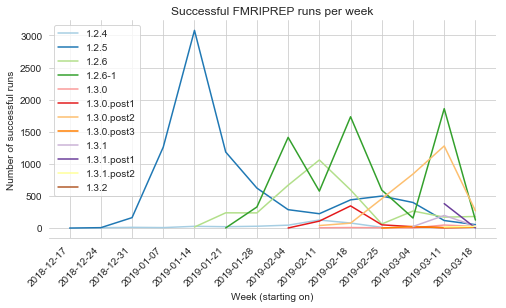

In [7]:
sns.set_style("whitegrid")

versions = sorted(all_successful_events_df['tags.release'].unique())[-12:]

sns.set_palette("Paired", len(versions))
fig,ax = plt.subplots(figsize=(8,4))

for version in versions:
    this_ver_df = all_successful_events_df[all_successful_events_df['tags.release'] == version]
    this_ver_grouped_df = this_ver_df[['date_minus_time', 'id']].resample('W-Mon', on='date_minus_time')['id'].count()
    plt.plot(this_ver_grouped_df.index, this_ver_grouped_df.values, label=version)

plt.ylabel("Number of successful runs")
plt.xlabel("Week (starting on)")
plt.title("Successful FMRIPREP runs per week")
ax.set_xticks(grouped_df.index)
ax.set_xticklabels(grouped_df.index, rotation=45, ha='right')
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y-%m-%d"))
sns.despine(left=True)
plt.legend()

## Success rate per week

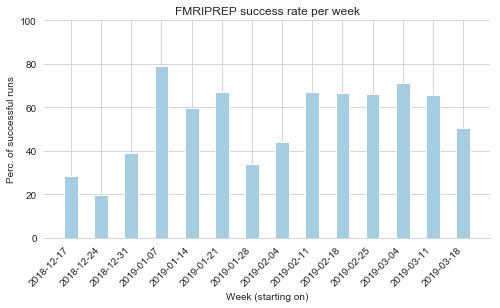

In [8]:
sns.set_style("whitegrid")
grouped_started_df = all_started_events_df[['date_minus_time', 'id']].resample('W-Mon', on='date_minus_time')['id'].count()
grouped_successful_df = all_successful_events_df2[['date_minus_time', 'id']].resample('W-Mon', on='date_minus_time')['id'].count()

grouped_df = grouped_successful_df/grouped_started_df*100

fig,ax = plt.subplots(figsize=(8,4))
plt.bar(grouped_df.index, grouped_df.values, width=3.2)
plt.ylabel("Perc. of successful runs")
plt.xlabel("Week (starting on)")
plt.title("FMRIPREP success rate per week")
plt.ylim([0,100])
ax.set_xticks(grouped_df.index)
ax.set_xticklabels(grouped_df.index, rotation=45, ha='right')
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y-%m-%d"))
sns.despine(left=True)

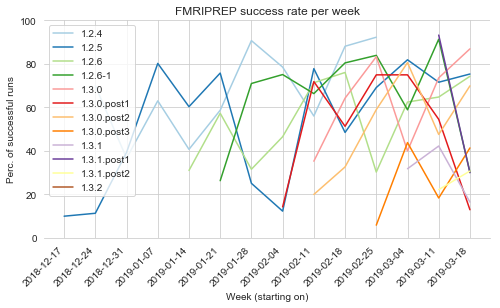

In [9]:
sns.set_style("whitegrid")

sns.set_palette("Paired", len(versions))
fig,ax = plt.subplots(figsize=(8,4))

for version in versions:
    this_ver_suc_df = all_successful_events_df2[all_successful_events_df2['tags.release'] == version]
    this_ver_sta_df = all_started_events_df[all_started_events_df['tags.release'] == version]
    
    grouped_started_df = this_ver_sta_df[['date_minus_time', 'id']].resample('W-Mon', on='date_minus_time')['id'].count()
    grouped_successful_df = this_ver_suc_df[['date_minus_time', 'id']].resample('W-Mon', on='date_minus_time')['id'].count()

    this_ver_grouped_df = grouped_successful_df/grouped_started_df*100
    plt.plot(this_ver_grouped_df.index, this_ver_grouped_df.values, label=version)

plt.ylabel("Perc. of successful runs")
plt.xlabel("Week (starting on)")
plt.title("FMRIPREP success rate per week")
plt.ylim([0,100])
ax.set_xticks(grouped_df.index)
ax.set_xticklabels(grouped_df.index, rotation=45, ha='right')
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y-%m-%d"))
sns.despine(left=True)
plt.legend()